In [61]:
import numpy as np
import pandas as pd
import pymysql as ms
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import sklearn.preprocessing as sp
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import RepeatedKFold

import sklearn.linear_model as lm
import sklearn.tree as tree
import sklearn.svm as svm
import sklearn.ensemble as ens
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import sklearn.metrics as met

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import dill
import pickle
import requests
from bs4 import BeautifulSoup
import pymysql

In [62]:
connection = pymysql.connect(
    host='localhost',  # 127.0.0.1
    password='12345678',
    database='ds'
)

OperationalError: (1045, "Access denied for user 'Test User'@'localhost' (using password: YES)")

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
df = pd.read_sql('select * from bina_db', con=connection).set_index('elan_id').drop(['id'], axis=1)

In [ ]:
class ColumnDropper():
    def __init__(self, columns):
        self.columns = columns

    def transform(self, _X, y=None):
        X = _X.copy(deep=True)
        return X.drop(self.columns, axis=1)

    def fit(self, X, y=None):
        return self

In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.loc[:, self.feature_names].copy(deep=True)

In [ ]:
class AverageCategoricalConverter(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, _X, y=None):
        X = _X.copy(deep=True)
        for feature in self.feature_names:
            feature_avg = X[[feature, 'qiymet']].groupby(by=feature).mean()
            feature_avg.rename(columns={'qiymet': f'{feature}_avg'}, inplace=True)
            X = X.merge(feature_avg, how='left', left_on=feature, right_index=True)
        return X


In [ ]:
class DataCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, _X, y=None):
        X = _X.copy(deep=True)
        X['mertebe'] = X.mertebe.apply(lambda x: x.split('/')[0].strip()).astype(int)
        X['sahe'] = X['sahe'].apply(lambda x: x.split(' ')[0]).astype(float)
        X['qiymet'] = X['qiymet'].apply(lambda x: ''.join(x.split(' ')[:-1])).astype(int)
        X['kvm_qiymet'] = X['kvm_qiymet'].apply(lambda x: ''.join(x.split(' ')[:-1])).astype(float)
        X['otaq_say'] = X['otaq_say'].astype(int)
        X['baxis_say'] = X['baxis_say'].astype(int)
        X['kupca'] = X['kupca'].apply(lambda x: 1 if x == 'var' else 0)
        X['ipoteka'] = X['ipoteka'].apply(lambda x: 1 if x == 'var' else 0)
        return X

In [ ]:
class FeatureGenerator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, _X, y=None):
        X = _X.copy(deep=True)
        X['mertebe_bina'] = X.mertebe.apply(lambda x: x.split('/')[1].strip()).astype(int)
        X['valyuta'] = X['qiymet'].apply(lambda x: x.split(' ')[-1].strip())

        df_tecili = pd.read_sql("select elan_id,info from bina_db where lower(info) like '%t_cil_%'",
                                connection).set_index('elan_id')
        temp_df = X.copy(deep=True)
        last_df = temp_df.merge(df_tecili[['info']], on='elan_id', how='left', suffixes=['', '_x'])
        last_df['tecili'] = last_df['info_x'].isna().apply(lambda x: 1 if x is False else 0)
        last_df = last_df.drop(['info_x'], axis=1)
        return last_df

In [ ]:
class PolynomialFeaturesGenerator(BaseEstimator, TransformerMixin):
    def __init__(self, pol_features):
        self.pol_features = pol_features

    def fit(self, X, y=None):
        return self

    def transform(self, _X, y=None):
        X = _X.copy(deep=True)

        if self.pol_features is None:
            pols = X
            self.pol_features = pols.columns
        else:
            pols = X[self.pol_features]

        poly = sp.PolynomialFeatures()

        poly_df = pd.DataFrame(poly.fit_transform(pols), index=X.index)
        poly_df = poly_df.iloc[:, len(self.pol_features) + 1:]
        cols = []
        for i in range(len(self.pol_features)):
            for j in range(i, len(self.pol_features)):
                cols.append(self.pol_features[i] + '_' + self.pol_features[j])
        poly_df.columns = cols
        X = X.join(poly_df, how='left')
        return X

In [ ]:
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, _X, y=None):
        X = _X.copy(deep=True)
        for feature in self.feature_names:
            cols = pd.get_dummies(X[feature], drop_first=True, prefix=f'{feature}').columns.values
            X[cols] = pd.get_dummies(X[feature], drop_first=True, prefix=f'{feature}')
        return X

In [ ]:
target = 'qiymet'

In [ ]:
polcols = ['sahe','mertebe','tecili','kupca','otaq_say']

In [ ]:
preprocessor_pipeline = Pipeline([
    ('feature_generator', FeatureGenerator()),
    ('cleaner', DataCleaner()),
    ('onehot_kateqoriya', CustomOneHotEncoder(['kateqoriya'])),
    ('drop_irrelevant', ColumnDropper(['kateqoriya', 'info', 'satici', 'elan_basliq', 'valyuta','kvm_qiymet'])),
    ('ortaqiymet_adres', AverageCategoricalConverter(['adres'])),
    ('drop_adres', ColumnDropper(['adres'])),
])



In [ ]:
data = preprocessor_pipeline.transform(df)

In [ ]:
polgenerator = PolynomialFeaturesGenerator(None)

In [ ]:
qiymet = data.qiymet

In [ ]:
data = polgenerator.transform(data.drop(columns=['qiymet'],axis=1))
data['qiymet'] = qiymet

In [ ]:
sns.boxplot(data.qiymet)

# Exploratory Data Analysis

In [ ]:
features = ['mertebe', 'otaq_say', 'sahe', 'qiymet', 'mertebe_bina']

In [ ]:
temp_data = data[features]

In [ ]:
temp_data.info()

In [63]:
temp_data.describe().T

,count,mean,std,min,25%,50%,75%,max
mertebe,23821.000,7.912,4.958,1.000,4.000,7.000,12.000,27.000
otaq_say,23821.000,2.790,0.873,1.000,2.000,3.000,3.000,18.000
sahe,23821.000,102.523,44.139,28.000,68.000,95.000,130.000,263.500
qiymet,23821.000,183927.314,109134.562,15000.000,110000.000,155000.000,230000.000,880000.000
mertebe_bina,23821.000,13.703,5.459,1.000,9.000,16.000,17.000,33.000


In [64]:
temp_data.shape

(23821, 5)

C:\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWar

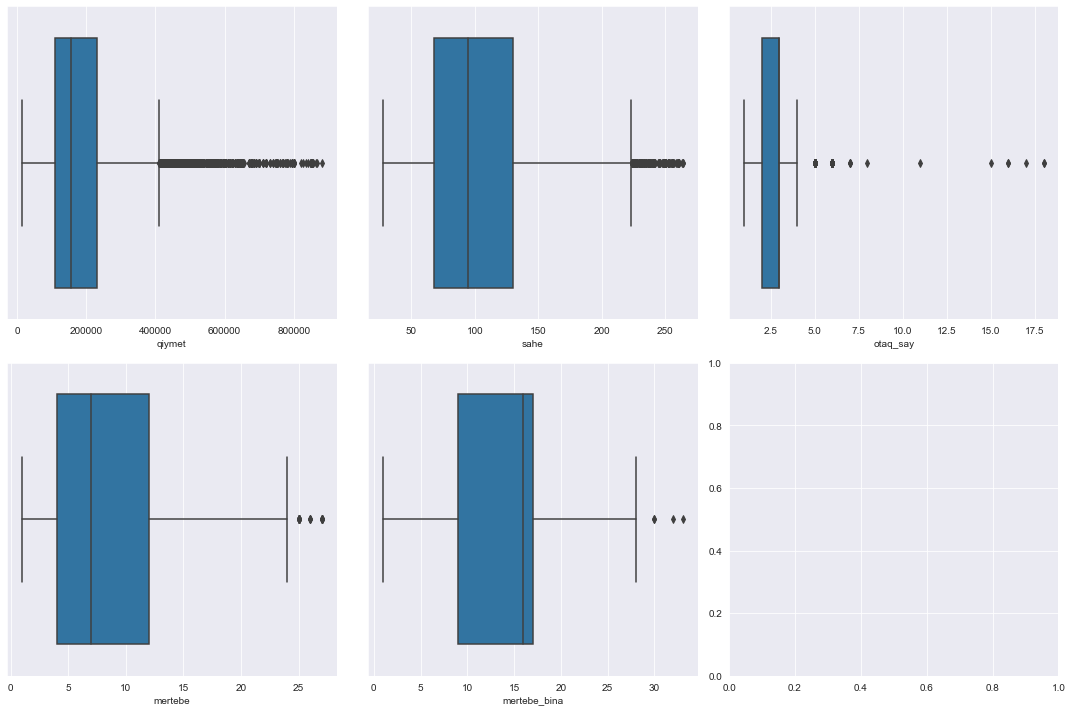

In [65]:
# Outlier Analysis
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
plt1 = sns.boxplot(temp_data['qiymet'], ax=axs[0, 0])
plt2 = sns.boxplot(temp_data['sahe'], ax=axs[0, 1])
plt3 = sns.boxplot(temp_data['otaq_say'], ax=axs[0, 2])
plt1 = sns.boxplot(temp_data['mertebe'], ax=axs[1, 0])
plt2 = sns.boxplot(temp_data['mertebe_bina'], ax=axs[1, 1])

plt.tight_layout()

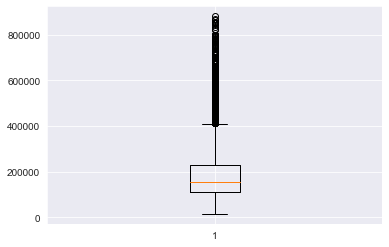

In [66]:
plt.boxplot(temp_data.qiymet)
low_threshold = temp_data.qiymet.quantile(0.0001)
high_threshold = temp_data.qiymet.quantile(0.99)
temp_data = temp_data[(temp_data.qiymet >= low_threshold) & (temp_data.qiymet <= high_threshold)]

In [67]:
temp_data.sahe.describe()

count   23580.000
mean      101.474
std        42.947
min        28.000
25%        68.000
50%        94.650
75%       128.000
max       263.500
Name: sahe, dtype: float64

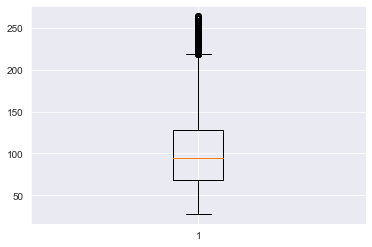

In [68]:
plt.boxplot(temp_data.sahe)
low_threshold = temp_data.sahe.quantile(0.001)
high_threshold = temp_data.sahe.quantile(0.99)
temp_data = temp_data[(temp_data.sahe >= low_threshold) & (temp_data.sahe <= high_threshold)]

In [69]:
temp_data.columns

Index(['mertebe', 'otaq_say', 'sahe', 'qiymet', 'mertebe_bina'], dtype='object')

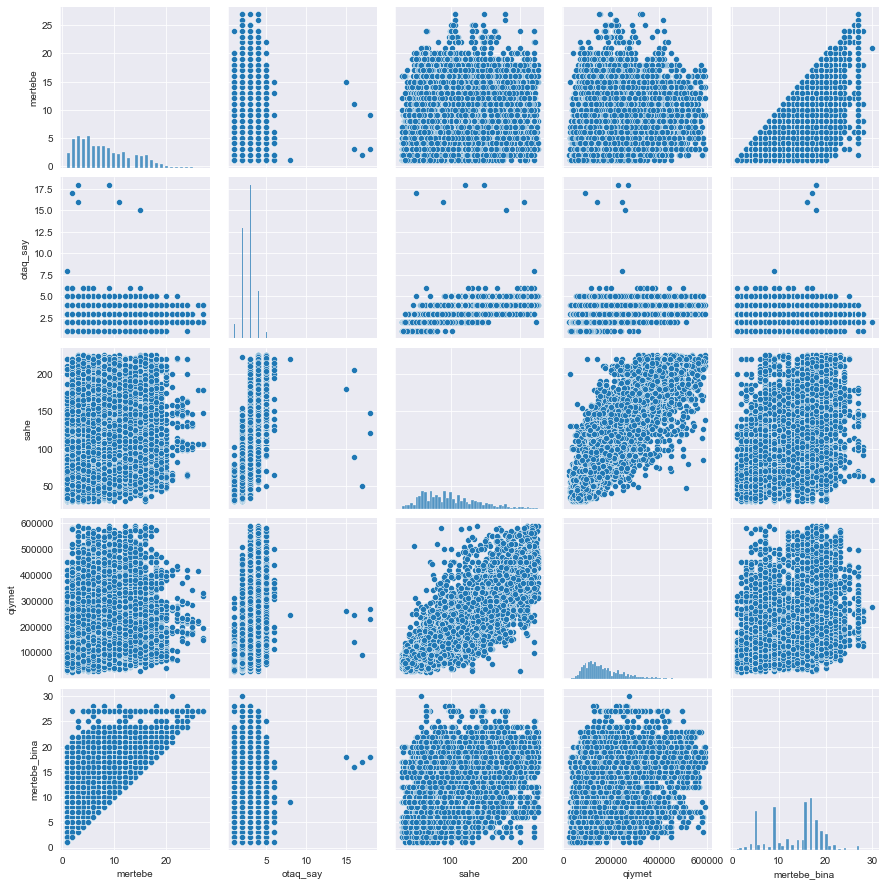

In [70]:
sns.pairplot(temp_data)
plt.show()

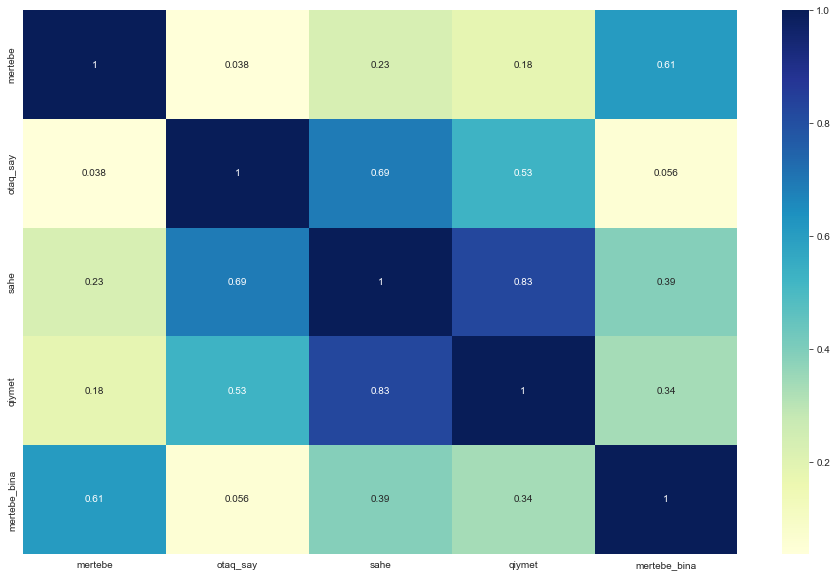

In [71]:
plt.figure(figsize=(16, 10))
sns.heatmap(temp_data.corr(), annot=True, cmap="YlGnBu")
plt.show()

In [72]:
data = temp_data.merge(data.drop(features, axis=1), on='elan_id')

In [73]:
data

,mertebe,otaq_say,sahe,qiymet,mertebe_bina,baxis_say,kupca,ipoteka,tecili,kateqoriya_Yeni tikili,...,mertebe_bina_mertebe_bina,mertebe_bina_tecili,mertebe_bina_kateqoriya_Yeni tikili,mertebe_bina_adres_avg,tecili_tecili,tecili_kateqoriya_Yeni tikili,tecili_adres_avg,kateqoriya_Yeni tikili_kateqoriya_Yeni tikili,kateqoriya_Yeni tikili_adres_avg,adres_avg_adres_avg
elan_id,,,,,,,,,,,,,,,,,,,,,
2969337,2,5,110.000,248000,7,91,1,0,1,1,...,49.000,7.000,7.000,1834437.905,1.000,1.000,262062.558,1.000,262062.558,68676784259.332
2801416,13,4,141.000,280000,19,296,1,0,1,1,...,361.000,19.000,19.000,3339583.180,1.000,1.000,175767.536,1.000,175767.536,30894226629.783
2903445,3,2,58.000,86000,5,1030,1,0,1,0,...,25.000,5.000,0.000,652049.878,1.000,0.000,130409.976,0.000,0.000,17006761721.251
2969332,9,3,194.000,475000,15,79,1,0,0,1,...,225.000,0.000,15.000,3930938.369,0.000,0.000,0.000,1.000,262062.558,68676784259.332
2969329,1,1,35.000,58500,5,436,1,0,0,0,...,25.000,0.000,0.000,623343.425,0.000,0.000,0.000,0.000,0.000,15542281029.446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787423,12,2,76.000,130000,17,268,1,0,0,1,...,289.000,0.000,17.000,6492024.613,0.000,0.000,0.000,1.000,381883.801,145835237299.133
2877382,6,2,62.000,150000,8,212,0,0,0,1,...,64.000,0.000,8.000,2253253.726,0.000,0.000,0.000,1.000,281656.716,79330505511.371
2956992,3,3,150.000,269900,18,396,1,0,0,1,...,324.000,0.000,18.000,5069820.883,0.000,0.000,0.000,1.000,281656.716,79330505511.371


In [74]:
y = data[target]
X = data.drop([target], axis=1)
X

,mertebe,otaq_say,sahe,mertebe_bina,baxis_say,kupca,ipoteka,tecili,kateqoriya_Yeni tikili,adres_avg,...,mertebe_bina_mertebe_bina,mertebe_bina_tecili,mertebe_bina_kateqoriya_Yeni tikili,mertebe_bina_adres_avg,tecili_tecili,tecili_kateqoriya_Yeni tikili,tecili_adres_avg,kateqoriya_Yeni tikili_kateqoriya_Yeni tikili,kateqoriya_Yeni tikili_adres_avg,adres_avg_adres_avg
elan_id,,,,,,,,,,,,,,,,,,,,,
2969337,2,5,110.000,7,91,1,0,1,1,262062.558,...,49.000,7.000,7.000,1834437.905,1.000,1.000,262062.558,1.000,262062.558,68676784259.332
2801416,13,4,141.000,19,296,1,0,1,1,175767.536,...,361.000,19.000,19.000,3339583.180,1.000,1.000,175767.536,1.000,175767.536,30894226629.783
2903445,3,2,58.000,5,1030,1,0,1,0,130409.976,...,25.000,5.000,0.000,652049.878,1.000,0.000,130409.976,0.000,0.000,17006761721.251
2969332,9,3,194.000,15,79,1,0,0,1,262062.558,...,225.000,0.000,15.000,3930938.369,0.000,0.000,0.000,1.000,262062.558,68676784259.332
2969329,1,1,35.000,5,436,1,0,0,0,124668.685,...,25.000,0.000,0.000,623343.425,0.000,0.000,0.000,0.000,0.000,15542281029.446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787423,12,2,76.000,17,268,1,0,0,1,381883.801,...,289.000,0.000,17.000,6492024.613,0.000,0.000,0.000,1.000,381883.801,145835237299.133
2877382,6,2,62.000,8,212,0,0,0,1,281656.716,...,64.000,0.000,8.000,2253253.726,0.000,0.000,0.000,1.000,281656.716,79330505511.371
2956992,3,3,150.000,18,396,1,0,0,1,281656.716,...,324.000,0.000,18.000,5069820.883,0.000,0.000,0.000,1.000,281656.716,79330505511.371


In [75]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(data=X_scaled, columns=X.columns)

In [76]:
X_scaled

,mertebe,otaq_say,sahe,mertebe_bina,baxis_say,kupca,ipoteka,tecili,kateqoriya_Yeni tikili,adres_avg,...,mertebe_bina_mertebe_bina,mertebe_bina_tecili,mertebe_bina_kateqoriya_Yeni tikili,mertebe_bina_adres_avg,tecili_tecili,tecili_kateqoriya_Yeni tikili,tecili_adres_avg,kateqoriya_Yeni tikili_kateqoriya_Yeni tikili,kateqoriya_Yeni tikili_adres_avg,adres_avg_adres_avg
0,-1.187,2.642,0.242,-1.221,-0.456,0.523,-0.564,1.287,0.610,0.877,...,-1.171,0.264,-0.607,-0.576,1.287,1.686,1.847,0.610,1.074,0.747
1,1.034,1.463,1.001,0.979,-0.178,0.523,-0.564,1.287,0.610,-0.291,...,1.012,1.899,0.908,0.393,1.287,1.686,1.007,0.610,0.274,-0.414
2,-0.985,-0.896,-1.031,-1.588,0.817,0.523,-0.564,1.287,-1.639,-0.905,...,-1.338,-0.009,-1.490,-1.337,1.287,-0.593,0.565,-1.639,-1.357,-0.841
3,0.226,0.283,2.299,0.246,-0.472,0.523,-0.564,-0.777,0.610,0.877,...,0.060,-0.690,0.403,0.774,-0.777,-0.593,-0.706,0.610,1.074,0.747
4,-1.389,-2.076,-1.594,-1.588,0.012,0.523,-0.564,-0.777,-1.639,-0.983,...,-1.338,-0.690,-1.490,-1.356,-0.777,-0.593,-0.706,-1.639,-1.357,-0.886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23334,0.832,-0.896,-0.590,0.612,-0.216,0.523,-0.564,-0.777,0.610,2.499,...,0.508,-0.690,0.656,2.423,-0.777,-0.593,-0.706,0.610,2.186,3.120
23335,-0.380,-0.896,-0.933,-1.038,-0.292,-1.913,-0.564,-0.777,0.610,1.143,...,-1.066,-0.690,-0.480,-0.306,-0.777,-0.593,-0.706,0.610,1.256,1.075
23336,-0.985,0.283,1.222,0.796,-0.042,0.523,-0.564,-0.777,0.610,1.143,...,0.753,-0.690,0.782,1.508,-0.777,-0.593,-0.706,0.610,1.256,1.075
23337,0.226,1.463,0.487,-0.854,0.055,0.523,-0.564,-0.777,-1.639,-0.761,...,-0.947,-0.690,-1.490,-0.940,-0.777,-0.593,-0.706,-1.639,-1.357,-0.752


In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)
X_train.shape, X_test.shape

((16337, 65), (7002, 65))

In [78]:
X_scaled

,mertebe,otaq_say,sahe,mertebe_bina,baxis_say,kupca,ipoteka,tecili,kateqoriya_Yeni tikili,adres_avg,...,mertebe_bina_mertebe_bina,mertebe_bina_tecili,mertebe_bina_kateqoriya_Yeni tikili,mertebe_bina_adres_avg,tecili_tecili,tecili_kateqoriya_Yeni tikili,tecili_adres_avg,kateqoriya_Yeni tikili_kateqoriya_Yeni tikili,kateqoriya_Yeni tikili_adres_avg,adres_avg_adres_avg
0,-1.187,2.642,0.242,-1.221,-0.456,0.523,-0.564,1.287,0.610,0.877,...,-1.171,0.264,-0.607,-0.576,1.287,1.686,1.847,0.610,1.074,0.747
1,1.034,1.463,1.001,0.979,-0.178,0.523,-0.564,1.287,0.610,-0.291,...,1.012,1.899,0.908,0.393,1.287,1.686,1.007,0.610,0.274,-0.414
2,-0.985,-0.896,-1.031,-1.588,0.817,0.523,-0.564,1.287,-1.639,-0.905,...,-1.338,-0.009,-1.490,-1.337,1.287,-0.593,0.565,-1.639,-1.357,-0.841
3,0.226,0.283,2.299,0.246,-0.472,0.523,-0.564,-0.777,0.610,0.877,...,0.060,-0.690,0.403,0.774,-0.777,-0.593,-0.706,0.610,1.074,0.747
4,-1.389,-2.076,-1.594,-1.588,0.012,0.523,-0.564,-0.777,-1.639,-0.983,...,-1.338,-0.690,-1.490,-1.356,-0.777,-0.593,-0.706,-1.639,-1.357,-0.886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23334,0.832,-0.896,-0.590,0.612,-0.216,0.523,-0.564,-0.777,0.610,2.499,...,0.508,-0.690,0.656,2.423,-0.777,-0.593,-0.706,0.610,2.186,3.120
23335,-0.380,-0.896,-0.933,-1.038,-0.292,-1.913,-0.564,-0.777,0.610,1.143,...,-1.066,-0.690,-0.480,-0.306,-0.777,-0.593,-0.706,0.610,1.256,1.075
23336,-0.985,0.283,1.222,0.796,-0.042,0.523,-0.564,-0.777,0.610,1.143,...,0.753,-0.690,0.782,1.508,-0.777,-0.593,-0.706,0.610,1.256,1.075
23337,0.226,1.463,0.487,-0.854,0.055,0.523,-0.564,-0.777,-1.639,-0.761,...,-0.947,-0.690,-1.490,-0.940,-0.777,-0.593,-0.706,-1.639,-1.357,-0.752


In [79]:

alphas = np.linspace(0, 10, 10)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=100)

hyper_param = {'alpha': alphas}

lasso_reg = Lasso()

grid_lasso = GridSearchCV(estimator=lasso_reg,
                          param_grid=hyper_param,
                          scoring='r2',
                          cv=cv,
                          n_jobs=-1,
                          return_train_score=True
                          )

grid_lasso.fit(X_train, y_train)

C:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.529e+12, tolerance: 1.444e+10
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=100),
             estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
        5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ])},
             return_train_score=True, scoring='r2')

In [80]:
grid_lasso.best_params_

{'alpha': 8.88888888888889}

In [81]:

from sklearn.linear_model import Ridge

model_params = {
    'tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            "max_depth": [None, 1, 3, 5, 7, 9, 11, 12],
        }
    },
    'ridge_regression': {
        'model': Ridge(),
        'params': {
            'alpha': np.arange(0, 1, 0.01)
        }
    }
}

In [82]:
l_reg = LinearRegression()
l_reg.fit(X_train, y_train)
l_reg.score(X_test,y_test)

0.7712649027722575

In [83]:
scores = []

for model_name, mp in model_params.items():
    grids = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False, n_jobs=-1)
    grids.fit(X_train, y_train)
    scores.append({
        'model': grids,
        'model_name': model_name,
        'best_score': grids.best_score_,
        'best_params': grids.best_params_
    })



In [84]:
scores.append({
    'model': l_reg,
    'model_name': 'linear_regression',
    'best_score': l_reg.score(X_test, y_test),
    'best_params': 'default'
})
scores.append({
    'model': grid_lasso,
    'model_name': 'lasso_regression',
    'best_score': grid_lasso.best_score_,
    'best_params': grid_lasso.best_params_
})

rand_forest = RandomForestRegressor()
rand_forest.fit(X_train,y_train)
scores.append({
    'model' : rand_forest,
    'model_name' : 'random_forest',
    'best_score' : rand_forest.score(X_test,y_test),
    'best_params' : 'default'
})

In [85]:
for model_score in scores:
    curr_model = model_score['model']
    model_score['mean_abserr_train'] = met.mean_absolute_error(y_train, curr_model.predict(X_train))
    model_score['median_abserr_train'] = met.median_absolute_error(y_train, curr_model.predict(X_train))

    model_score['mean_abserr_test'] = met.mean_absolute_error(y_test, curr_model.predict(X_test))
    model_score['median_abserr_test'] = met.median_absolute_error(y_test, curr_model.predict(X_test))


In [86]:
model_scores = pd.DataFrame(scores, columns=['model_name', 'best_score', 'best_params','mean_abserr_train','median_abserr_train','mean_abserr_test','median_abserr_test'])
model_scores

,model_name,best_score,best_params,mean_abserr_train,median_abserr_train,mean_abserr_test,median_abserr_test
0,tree,0.795,{'max_depth': 7},25781.915,16819.732,27668.053,17298.676
1,ridge_regression,0.805,{'alpha': 0.99},27613.646,17807.575,28187.913,17905.565
2,linear_regression,0.771,default,27615.331,17777.334,28197.088,17869.930
3,lasso_regression,0.805,{'alpha': 8.88888888888889},27608.532,17791.983,28099.468,17857.834
4,random_forest,0.842,default,8405.165,4903.000,22730.230,13227.500
